In [123]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#Set numpy and Tensorflow random seed to mask sure experiment reproducible(only works in CPU mode).
from numpy.random import seed
seed(123)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(123)
from skimage import io
import cv2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir())

# Any results you write to the current directory are saved as output.

['.ipynb_checkpoints', 'Untitled.ipynb', 'train.txt', 'how does it works wtf .ipynb', 'val.txt', 'testing.h5', 'model-sdc-seg-v2.h5', 'labels', 'how does it works but wtf this is real shit.ipynb', '__pycache__', 'Unet_data', 'good_but_bad.h5', 'CNRS-HDS-CAR5-LANES-20230606T174121Z-001', 'testing.ipynb', 'Segmentation.py', 'dataset.yaml', 'masks', 'model-sdc-seg-v2_good_but_bad.h5', 'learning.ipynb', 'images', 'get_all_masks.ipynb', 'toto']


In [124]:
image_path = 'images/'
mask_path = 'masks/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [125]:
image_list = ['images/'+item+'.jpg' for item in pd.Series([item.split('mask_')[-1][:-4] for item in mask_list]).sort_values().tolist()]

In [126]:
mask_list = ['masks/mask_'+item+'.png' for item in pd.Series([item.split('mask_')[-1][:-4] for item in mask_list]).sort_values().tolist()]

/tmp/ipykernel_28924/1948649445.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_28924/1948649445.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

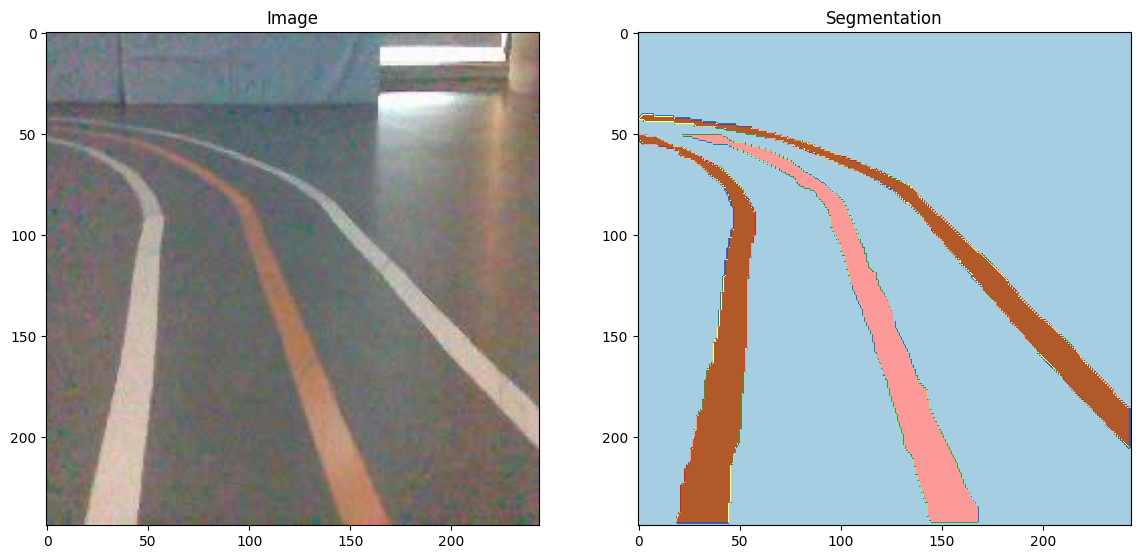

In [127]:
from skimage import io

N = 50
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])
#mask = np.where(mask != 0, 1, mask)


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

In [128]:
from tqdm import tqdm

In [129]:
height = 720
width = 1280
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

def augment_dim_arr(arr_census, augmentation):
    new_array = np.broadcast_to(arr_census[:, :, np.newaxis], arr_census.shape + (1,))
    new_array = np.broadcast_to(new_array, arr_census.shape + (augmentation,))
    return new_array


for n in tqdm(range(len(image_list))):
    img = cv2.resize(io.imread(image_list[n]), (1280,720), interpolation = cv2.INTER_NEAREST)
    #img = cv2.resize(cv2.cvtColor(cv2.imread(image_list[n], cv2.IMREAD_GRAYSCALE), cv2.COLOR_GRAY2RGB), (1280,720), interpolation = cv2.INTER_NEAREST)
    mask = cv2.resize(io.imread(mask_list[n]), (1280,720))
    #mask_road = np.zeros((height, width, 1), dtype=np.int8)
    #mask_road[np.where(mask==255)[0], np.where(mask==255)[1]]=1
    #mask_road[np.where(mask==100)[0], np.where(mask==100)[1]]=2
    
    mask = np.where(mask>=225, 255, mask)
    mask = np.where((mask<225) & (mask >=110), 0, mask)
    mask = np.where((mask<110) & (mask >=75), 100, mask)
    mask = np.where(mask<75, 0, mask)
    
    
    mask_road = np.where(mask == 255, 1, mask)
    mask_road = np.where(mask_road == 100, 2, mask_road)
    mask_road = np.expand_dims(mask_road, axis=2)
    
    images[n] = img
    masks[n] = mask_road

100%|█████████████████████████████████████████| 781/781 [00:08<00:00, 96.08it/s]


In [130]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [131]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [132]:
train_images.shape, val_images.shape, test_images.shape

((624, 720, 1280, 3), (100, 720, 1280, 3), (57, 720, 1280, 3))

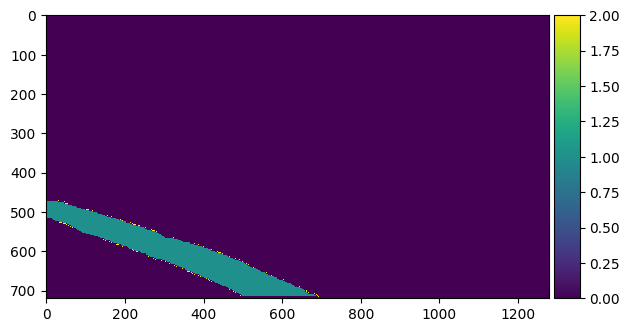

In [133]:
io.imshow(test_masks[10])

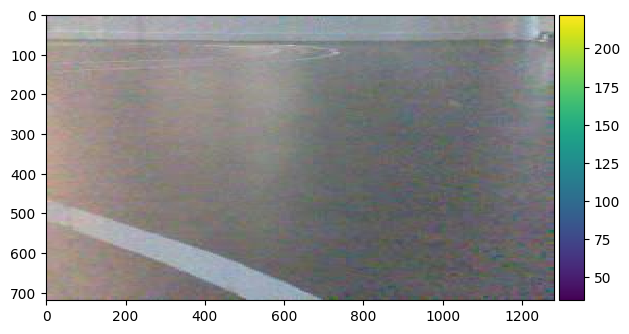

In [134]:
io.imshow(test_images[10])

In [135]:
cmp = 0
for image in train_images:
    io.imsave("Unet_data/train_imgs/train/img"+str(cmp)+'.png', image.astype(np.uint8))
    cmp+=1

In [136]:
cmp = 0
for image in train_masks:
    io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img0.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img1.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img2.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img3.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img4.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/300358787

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img43.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img44.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img45.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img46.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img47.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img88.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img89.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img90.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img91.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img92.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img133.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img134.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img135.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img136.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img137.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img176.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img177.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img178.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img179.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img180.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img221.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img222.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img223.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img224.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img225.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img266.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img267.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img268.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img269.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img270.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img311.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img312.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img313.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img314.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img315.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img356.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img357.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img358.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img359.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img360.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img403.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img404.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img405.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img406.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img407.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img448.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img449.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img450.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img451.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img452.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img493.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img494.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img495.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img496.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img497.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img537.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img538.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img539.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img540.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img541.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img580.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img581.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img582.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img583.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img584.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924

/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img622.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3003587879.py:3: UserWarning: Unet_data/train_masks/train/img623.png is a low contrast image
  io.imsave("Unet_data/train_masks/train/img"+str(cmp)+'.png', np.squeeze(image))


In [137]:
cmp

624

In [138]:
cmp = 624+1
for image in test_masks:
    io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img625.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img626.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img627.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img628.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img629.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: Us

/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img675.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img676.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img677.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img678.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: UserWarning: Unet_data/test_masks/test/img679.png is a low contrast image
  io.imsave("Unet_data/test_masks/test/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/3778738309.py:3: Us

In [139]:
cmp = 624+1
for image in test_images:
    io.imsave("Unet_data/test_imgs/test/img"+str(cmp)+'.png', image.astype(np.uint8))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [140]:
cmp

682

In [141]:
cmp = 682+1
for image in val_images:
    io.imsave("Unet_data/val_imgs/val/img"+str(cmp)+'.png', image.astype(np.uint8))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

In [142]:
cmp = 682+1
for image in val_masks:
    io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
              #np.repeat(image.astype(np.uint8)[:, :, np.newaxis], 3, axis=2))
    cmp+=1

/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img683.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img684.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img685.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img686.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img687.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data

/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img734.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img735.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img736.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img737.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data/val_masks/val/img738.png is a low contrast image
  io.imsave("Unet_data/val_masks/val/img"+str(cmp)+'.png', np.squeeze(image))
/tmp/ipykernel_28924/2862074754.py:3: UserWarning: Unet_data

In [49]:
toto = augment_dim_arr(cv2.resize(io.imread(image_list[n], as_gray=True), (1280,720), interpolation = cv2.INTER_NEAREST), 3)

toto = io.imread(image_list[n], as_gray=True)
toto = np.round(np.interp(toto, (toto.min(), toto.max()), (0, 255)))
cv2.cvtColor(toto, cv2.COLOR_GRAY2RGB)

error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<3, 4>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [65]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [66]:
# Build U-Net model
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

2023-06-06 15:08:30.651241: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 720, 1280,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 720, 1280, 8  224         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 720, 1280, 8  584         ['conv2d[0][0]']                 
                                )                                                             

In [67]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', 
                    verbose=1, 
                    save_best_only=True
                   )
]

results = model.fit(train_images, 
                    train_masks, 
                    batch_size=5, 
                    epochs=5, 
                    callbacks=callbacks,
                    validation_data=(val_images, val_masks)
                   )

Epoch 1/5


2023-06-06 15:08:37.904047: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1188864000 exceeds 10% of free system memory.


43/43 [==============================] - ETA: 0s - loss: 0.5637
Epoch 1: val_loss improved from inf to 0.50702, saving model to model-sdc-seg-v2.h5
43/43 [==============================] - 371s 9s/step - loss: 0.5637 - val_loss: 0.5070 - lr: 0.0010
Epoch 2/5
43/43 [==============================] - ETA: 0s - loss: 0.4153
Epoch 2: val_loss improved from 0.50702 to 0.31520, saving model to model-sdc-seg-v2.h5
43/43 [==============================] - 372s 9s/step - loss: 0.4153 - val_loss: 0.3152 - lr: 0.0010
Epoch 3/5
43/43 [==============================] - ETA: 0s - loss: 0.2091 
Epoch 3: val_loss improved from 0.31520 to 0.09478, saving model to model-sdc-seg-v2.h5
43/43 [==============================] - 450s 11s/step - loss: 0.2091 - val_loss: 0.0948 - lr: 0.0010
Epoch 4/5
43/43 [==============================] - ETA: 0s - loss: 6.0721 
Epoch 4: val_loss did not improve from 0.09478
43/43 [==============================] - 465s 11s/step - loss: 6.0721 - val_loss: 0.5246 - lr: 0.0010

In [68]:
model.save('testing.h5')

1/1 [==============================] - 1s 529ms/step


Text(0.5, 1.0, 'Ground truth')

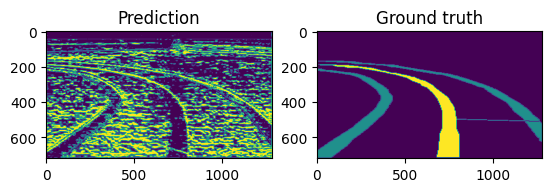

In [69]:
NUMBER = 0
my_preds = model.predict(np.expand_dims(val_images[NUMBER], 0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i >= 0.2 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(height, width))
ax[0].set_title('Prediction')
ax[1].imshow(val_masks[NUMBER].reshape(height, width))
ax[1].set_title('Ground truth')

In [86]:
temp = np.squeeze(model.predict(np.expand_dims(val_images[8], 0))[0])
temp = np.round(np.interp(temp, (temp.min(), temp.max()), (0, 255)))

1/1 [==============================] - 0s 300ms/step


(array([[  5.,   3.,   9., ...,   0.,   1.,   1.],
        [412., 258.,  46., ...,   0.,   0.,   0.],
        [  9.,   5.,   9., ...,  31.,   8.,   5.],
        ...,
        [  7.,  10.,   8., ...,   2.,   2.,   0.],
        [  6.,   3.,   2., ..., 143.,  16.,   6.],
        [  4.,   0.,   0., ...,  42., 592.,  65.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 1280 BarContainer objects>)

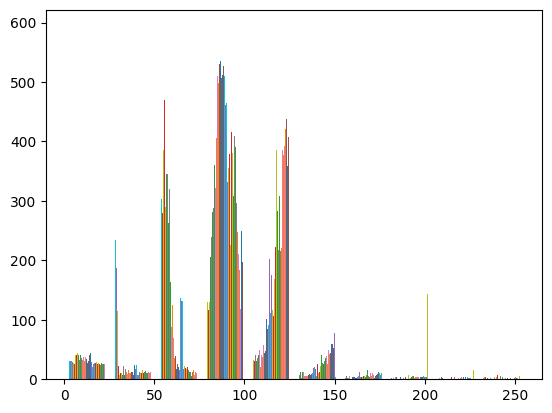

In [78]:
plt.hist(temp)

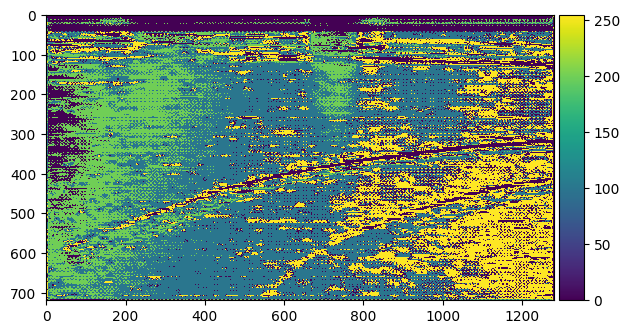

In [87]:
temp = np.where(temp >= 130, 0, temp)
temp = np.where((temp>=105) & (temp<130) , 255, temp)
temp = np.where((temp<105) & (temp >=100), 0, temp)
temp = np.where((temp<100) & (temp >=75), 100, temp)
temp = np.where((temp<75) & (temp>=50), 200, temp)
temp = np.where(temp < 50, 0, temp)
io.imshow(temp)

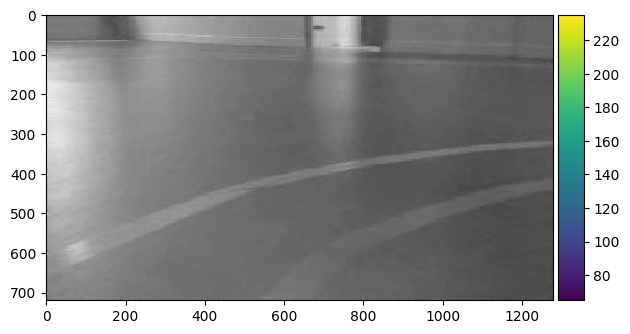

In [80]:
io.imshow(np.squeeze(val_images[8]))

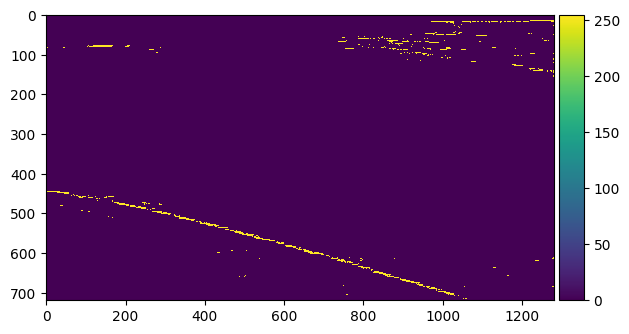

In [75]:
io.imshow(temp)

In [50]:
temp = cv2.resize(io.imread(mask_list[12]), (1280,720))
mask_road = np.where(temp == 255, 1, temp)
mask_road = np.where(mask_road == 100, 2, mask_road)
mask_road = np.expand_dims(mask_road, axis=2)

(array([[720.,   0.,   0., ...,   0.,   0.,   0.],
        [720.,   0.,   0., ...,   0.,   0.,   0.],
        [720.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [720.,   0.,   0., ...,   0.,   0.,   0.],
        [720.,   0.,   0., ...,   0.,   0.,   0.],
        [720.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 1280 BarContainer objects>)

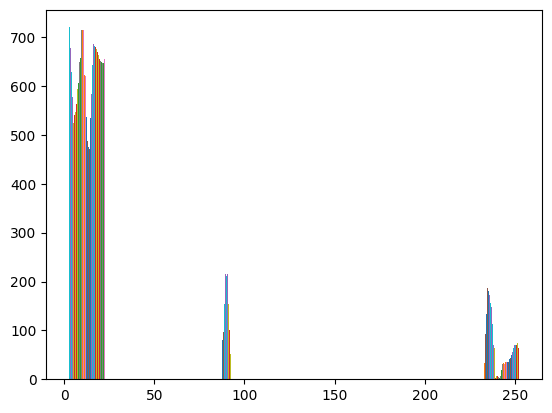

In [88]:
plt.hist(cv2.resize(io.imread(mask_list[32]), (1280,720), interpolation = cv2.INTER_NEAREST ))

In [89]:
np.unique(cv2.resize(io.imread(mask_list[32]), (1280,720), interpolation = cv2.INTER_NEAREST ))

array([  0, 100, 255], dtype=uint8)

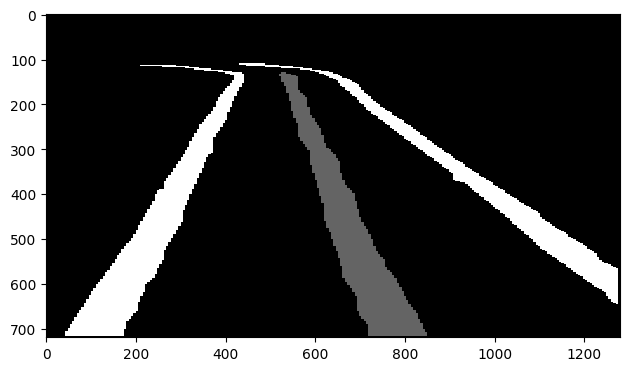

In [90]:
test = cv2.resize(io.imread(mask_list[32]), (1280,720), interpolation = cv2.INTER_NEAREST)
test = np.where(test>=225, 255, test)
test = np.where((test<225) & (test >=110), 0, test)
test = np.where((test<110) & (test >=75), 100, test)
test = np.where(test<75, 0, test)

io.imshow(test)

In [12]:
np.unique(cv2.resize(image_seuillee, (1280, 720)))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

/home/tom/.local/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


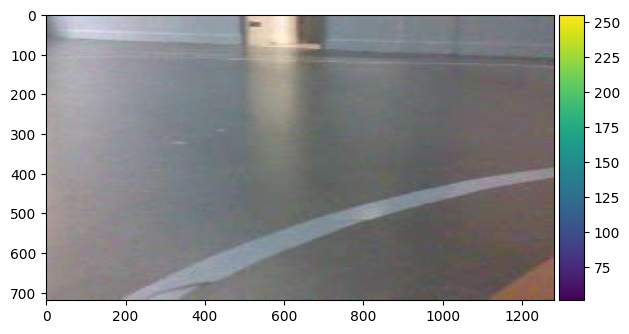

In [22]:
io.imshow(val_images[0])

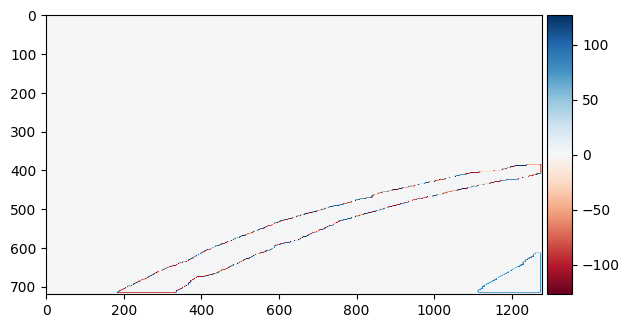

In [21]:
io.imshow(val_masks[0])